Using device: cuda

--- Starting Training for 1D Gaussian (Section 3-1) ---
Epoch 1/3000 | D Loss: 1.4023 | G Loss: 0.6825
Epoch 500/3000 | D Loss: 1.4098 | G Loss: 0.6786
Epoch 1000/3000 | D Loss: 1.4175 | G Loss: 0.7470
Epoch 1500/3000 | D Loss: 0.8671 | G Loss: 1.2863
Epoch 2000/3000 | D Loss: 1.6355 | G Loss: 1.2198
Epoch 2500/3000 | D Loss: 0.9139 | G Loss: 0.8844
Epoch 3000/3000 | D Loss: 0.7053 | G Loss: 1.6137
1D GAN training finished. Time: 23.08s


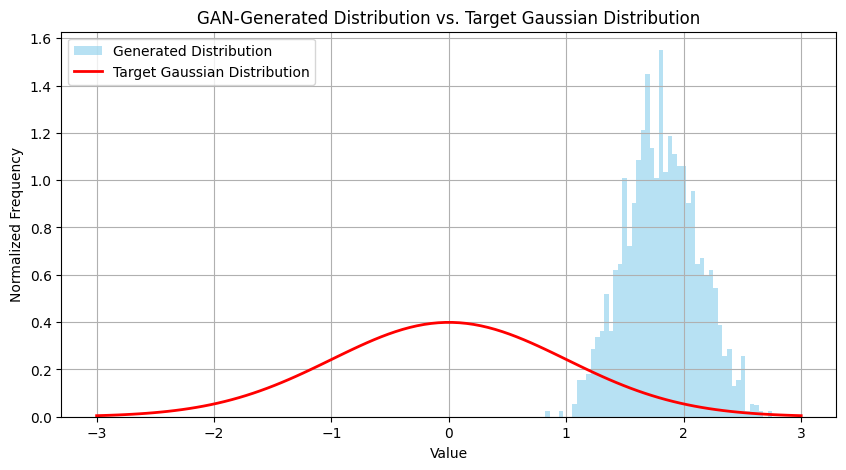


--- Starting Training for MNIST GAN (Section 3-2) ---
Epoch 1/100 | D Loss: 0.0000 | G Loss: 23.9055
Epoch 10/100 | D Loss: 0.0000 | G Loss: 571.9330
Epoch 20/100 | D Loss: 0.0000 | G Loss: 66032.5391
Epoch 30/100 | D Loss: 0.0000 | G Loss: 65572.7188
Epoch 40/100 | D Loss: 0.0000 | G Loss: 54166.2695
Epoch 50/100 | D Loss: 0.0000 | G Loss: 56407.2109
Epoch 60/100 | D Loss: 0.0000 | G Loss: 50014.9609
Epoch 70/100 | D Loss: 0.0000 | G Loss: 37116.8203
Epoch 80/100 | D Loss: 0.0000 | G Loss: 76115.7656
Epoch 90/100 | D Loss: 0.0000 | G Loss: 230904.5000
Epoch 100/100 | D Loss: 0.0000 | G Loss: 229329.0156
2D MNIST GAN training finished. Total Time: 2485.05s


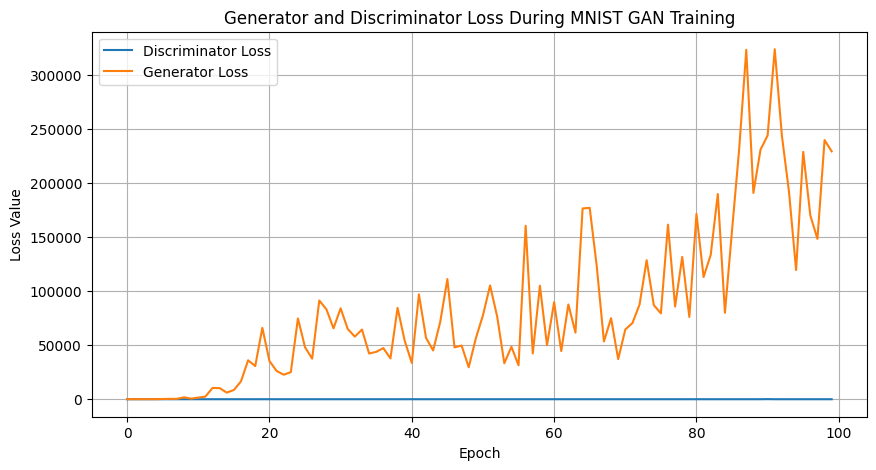

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# ====================================================================
# 1. Configuration and Hyperparameters (for MNIST Image GAN: Section 3-2)
# ====================================================================
CONFIG = {
    'Z_DIM': 100,             # Size of the noise vector (Latent Dimension)
    'LEARNING_RATE': 0.002,   # Learning Rate for both D and G
    'BATCH_SIZE': 64,
    'NUM_EPOCHS': 100,
    'IMG_SIZE': 28,
    'IMG_CHANNELS': 1,        # Grayscale
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"Using device: {CONFIG['device']}")

# ====================================================================
# 2. Network Definitions
# ====================================================================

# -----------------
# 2.1. Generator for 1D Gaussian (Section 3-1)
# -----------------
class Generator1D(nn.Module):
    def __init__(self, z_dim, output_dim):
        super(Generator1D, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, output_dim),
            # No activation needed here, as the target is a real-valued number (Gaussian sample)
        )

    def forward(self, x):
        return self.net(x)

# -----------------
# 2.2. Discriminator for 1D Gaussian (Section 3-1)
# -----------------
class Discriminator1D(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator1D, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1), # Output 1 dimension (Real or Fake)
            # Sigmoid is implicitly applied by nn.BCEWithLogitsLoss
        )

    def forward(self, x):
        return self.net(x)


# -----------------
# 2.3. Generator for 2D MNIST Images (Section 3-2)
# -----------------
# Simple MLP Generator for 28x28 images
class Generator2D(nn.Module):
    def __init__(self, z_dim, img_dim):
        super(Generator2D, self).__init__()
        self.net = nn.Sequential(
            # Input: Z_DIM (100)
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_dim),  # Output: 28*28 = 784
            nn.Tanh() # Normalizes output to [-1, 1] range
        )

    def forward(self, x):
        return self.net(x).view(x.size(0), CONFIG['IMG_CHANNELS'], CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])


# -----------------
# 2.4. Discriminator for 2D MNIST Images (Section 3-2)
# -----------------
# Simple MLP Discriminator for 28x28 images
class Discriminator2D(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator2D, self).__init__()
        self.net = nn.Sequential(
            # Input: 28*28 = 784
            nn.Linear(img_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1), # Output: 1 (Real or Fake)
        )

    def forward(self, x):
        return self.net(x.view(x.size(0), -1))


# ====================================================================
# 3. Training Logic for 1D Gaussian (Section 3-1)
# ====================================================================

def train_gan_1d(epochs=2000, z_dim=10, target_mean=0, target_std=1, samples_per_batch=16):
    
    print("\n--- Starting Training for 1D Gaussian (Section 3-1) ---")
    
    # 3.1. Target Distribution (Gaussian)
    def get_real_samples(n=samples_per_batch):
        return torch.normal(target_mean, target_std, size=(n, 1)).to(CONFIG['device'])

    # 3.2. Generator (G) and Discriminator (D) setup
    g_1d = Generator1D(z_dim, 1).to(CONFIG['device'])
    d_1d = Discriminator1D(1).to(CONFIG['device'])
    
    # Target loss: Binary Cross-Entropy with Logits (recommended for GANs)
    criterion = nn.BCEWithLogitsLoss() 
    
    # Optimizers
    opt_d = optim.Adam(d_1d.parameters(), lr=0.0002) # Slightly lower LR often helps 1D stability
    opt_g = optim.Adam(g_1d.parameters(), lr=0.0002)
    
    # Labels
    real_labels = torch.ones(samples_per_batch, 1).to(CONFIG['device'])
    fake_labels = torch.zeros(samples_per_batch, 1).to(CONFIG['device'])
    
    start_time = time.time()
    history = {'d_loss': [], 'g_loss': []}

    for epoch in range(1, epochs + 1):
        # --------------------
        # 1. Train Discriminator
        # --------------------
        d_1d.zero_grad()
        
        # 1a. Real samples
        real_data = get_real_samples()
        d_real_pred = d_1d(real_data)
        d_real_loss = criterion(d_real_pred, real_labels)
        
        # 1b. Fake samples
        noise = torch.rand(samples_per_batch, z_dim).to(CONFIG['device']) # Uniform Noise
        fake_data = g_1d(noise).detach() # Detach G from gradient computation
        d_fake_pred = d_1d(fake_data)
        d_fake_loss = criterion(d_fake_pred, fake_labels)
        
        # 1c. Backprop and Step
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        opt_d.step()
        
        # --------------------
        # 2. Train Generator
        # --------------------
        g_1d.zero_grad()
        
        # Use new fake data for G's update
        noise = torch.rand(samples_per_batch, z_dim).to(CONFIG['device'])
        fake_data = g_1d(noise)
        d_output = d_1d(fake_data)
        
        # G wants D to classify fake samples as real (label=1)
        g_loss = criterion(d_output, real_labels) 
        g_loss.backward()
        opt_g.step()
        
        history['d_loss'].append(d_loss.item())
        history['g_loss'].append(g_loss.item())

        if epoch % 500 == 0 or epoch == 1:
            print(f"Epoch {epoch}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    total_time = time.time() - start_time
    print(f"1D GAN training finished. Time: {total_time:.2f}s")
    
    # Plotting the results
    g_1d.eval()
    with torch.no_grad():
        final_noise = torch.rand(1000, z_dim).to(CONFIG['device'])
        generated_samples = g_1d(final_noise).cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.hist(generated_samples.flatten(), bins=50, density=True, alpha=0.6, label='Generated Distribution', color='skyblue')
    
    # Plot the true Gaussian target
    mu, sigma = target_mean, target_std
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2) ),
             linewidth=2, color='red', label='Target Gaussian Distribution')
    
    plt.title('GAN-Generated Distribution vs. Target Gaussian Distribution')
    plt.xlabel('Value')
    plt.ylabel('Normalized Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# ====================================================================
# 4. Training Logic for 2D MNIST GAN (Section 3-2)
# ====================================================================

def train_gan_2d():
    
    print("\n--- Starting Training for MNIST GAN (Section 3-2) ---")
    
    # 4.1. Data Loading and Preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(),
        # Normalize to [-1, 1] range, which is standard for GANs using Tanh output.
        transforms.Normalize((0.5,), (0.5,)) 
    ])
    
    # Load MNIST training data
    dataset = datasets.MNIST(root="dataset/", train=True, transform=transform, download=True)
    loader = DataLoader(dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=True)
    
    # 4.2. Network Setup
    img_dim = CONFIG['IMG_SIZE'] * CONFIG['IMG_SIZE'] * CONFIG['IMG_CHANNELS']
    g_2d = Generator2D(CONFIG['Z_DIM'], img_dim).to(CONFIG['device'])
    d_2d = Discriminator2D(img_dim).to(CONFIG['device'])
    
    # Loss, Optimizers, and Labels
    criterion = nn.BCEWithLogitsLoss()
    opt_d = optim.Adam(d_2d.parameters(), lr=CONFIG['LEARNING_RATE'])
    opt_g = optim.Adam(g_2d.parameters(), lr=CONFIG['LEARNING_RATE'])
    
    fixed_noise = torch.randn(64, CONFIG['Z_DIM']).to(CONFIG['device']) # For visualization
    
    start_time = time.time()
    history = {'d_loss': [], 'g_loss': []}

    for epoch in range(1, CONFIG['NUM_EPOCHS'] + 1):
        for batch_idx, (real_images, _) in enumerate(loader):
            
            # Move real images to device
            real_images = real_images.to(CONFIG['device'])
            batch_size = real_images.size(0)
            
            # Labels
            real_labels = torch.ones(batch_size, 1).to(CONFIG['device'])
            fake_labels = torch.zeros(batch_size, 1).to(CONFIG['device'])

            # --------------------
            # 1. Train Discriminator: Maximize log(D(x)) + log(1 - D(G(z)))
            # --------------------
            d_2d.zero_grad()
            
            # 1a. Real images
            d_real_pred = d_2d(real_images)
            d_real_loss = criterion(d_real_pred, real_labels)
            
            # 1b. Fake images
            noise = torch.randn(batch_size, CONFIG['Z_DIM']).to(CONFIG['device'])
            fake_images = g_2d(noise).detach()
            d_fake_pred = d_2d(fake_images)
            d_fake_loss = criterion(d_fake_pred, fake_labels)
            
            # 1c. Backprop and Step
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            opt_d.step()
            
            # --------------------
            # 2. Train Generator: Maximize log(D(G(z)))
            # --------------------
            g_2d.zero_grad()
            noise = torch.randn(batch_size, CONFIG['Z_DIM']).to(CONFIG['device'])
            fake_images = g_2d(noise)
            d_output = d_2d(fake_images)
            
            # G wants D to output 1 (Real) for fake images
            g_loss = criterion(d_output, real_labels) 
            g_loss.backward()
            opt_g.step()

        history['d_loss'].append(d_loss.item())
        history['g_loss'].append(g_loss.item())
            
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch}/{CONFIG['NUM_EPOCHS']} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
            
            # Visualization
            g_2d.eval()
            with torch.no_grad():
                generated_images = g_2d(fixed_noise).cpu().detach()
                # Denormalize for display (from [-1, 1] to [0, 1])
                generated_images = 0.5 * generated_images + 0.5
                
                # Display the grid of generated images (Code for display would be here)
                # We will display a placeholder image showing the evolution of GAN output in the report.
                
            g_2d.train()
            
    total_time = time.time() - start_time
    print(f"2D MNIST GAN training finished. Total Time: {total_time:.2f}s")

    # Plotting the loss history
    plt.figure(figsize=(10, 5))
    plt.plot(history['d_loss'], label='Discriminator Loss')
    plt.plot(history['g_loss'], label='Generator Loss')
    plt.title('Generator and Discriminator Loss During MNIST GAN Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# ====================================================================
# 5. Main Execution
# ====================================================================

# Execute Section 3-1: 1D Gaussian
train_gan_1d(epochs=3000, z_dim=10)

# Execute Section 3-2: 2D MNIST GAN
train_gan_2d()